#Transfer learning and fine-tuning
In this tutorial, you will learn how to classify images of cats and dogs by using transfer learning from a pre-trained network.

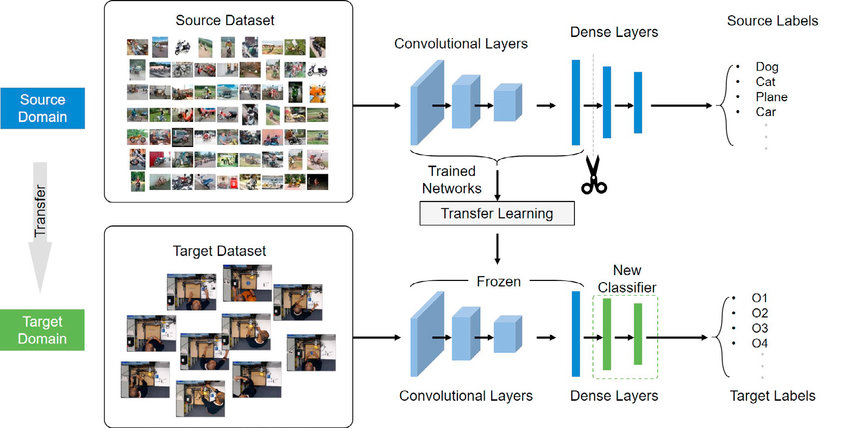

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Examine and understand the data
In this tutorial, you will use a dataset containing several thousand images of cats and dogs. Download and extract a zip file containing the images, then create a tf.data.Dataset for training and validation using the tf.keras.utils.image_dataset_from_directory utility. You can learn more about loading images in this tutorial.

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [ ]:
!unzip /content/cats_and_dogs_filtered.zip

In [127]:
train_dir ="/content/cats_and_dogs_filtered/train" 
validation_dir = "/content/cats_and_dogs_filtered/validation" 

In [128]:
#Size of the batches of data
BATCH_SIZE = 32
#Size to resize images
IMG_SIZE = (160, 160)

In [129]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [130]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


### Show the first nine images and labels from the training set:

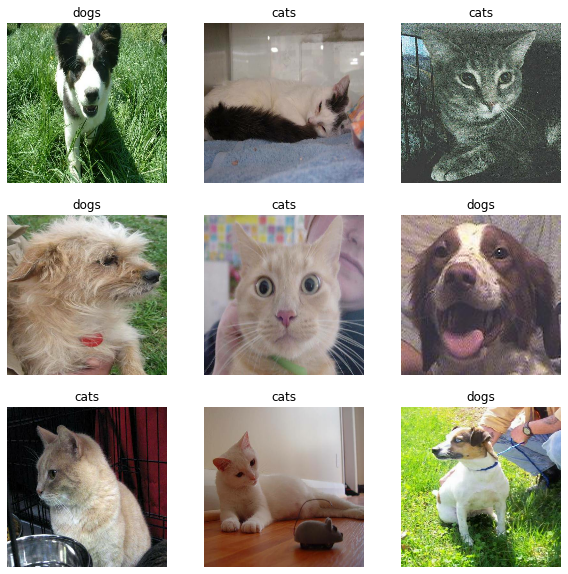

In [131]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Split Validation into Validation and test

In [132]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 32


In [133]:
test_dataset = validation_dataset.take(5)
validation_dataset = validation_dataset.skip(5)

In [134]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 27
Number of validation batches: 5


### Data augmentation

In [135]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

### Rescale image pixel values
- MobileNetV2 model: Expects pixel values in `[-1, 1]`
- Pixel values in the images are in `[0, 255]`.

In [136]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Create the base model
- MobileNet V2 model developed at Google.
- pre-trained on the ImageNet dataset, consisting of 1.4M images and 1000 classes.

In [137]:
IMG_SHAPE = (160,160,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # load the model without the classification layers at the top
                                               weights='imagenet')

## Feature Extraction
- Use the representations learned by the pretrained model to extract meaningful features from new samples. 

- Add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

### Freeze the convolutional base
Prevents the weights in a given layer from being updated during training

In [138]:
# Freeze the convolutional base
base_model.trainable = False

In [139]:
# The base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Feature extractor
- Converts each 160x160x3 image into a 5x5x1280 block of features. 

In [140]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape, label_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 160, 160, 3) (32,)
(32, 5, 5, 1280)


### Convert the features to a single 1280-element vector per image (flatten)

In [141]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# test it's results
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


### Add a classification head (Predication Layer)
- Convert the features into a single prediction per image.

In [142]:
prediction_layer = tf.keras.layers.Dense(1)

# test it's results
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Build The model
- chaining together the data augmentation, rescaling, base_model and feature extractor layers.

In [143]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x) # flatten 1-D vector
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model
- Since there are two classes, we will use the ``tf.keras.losses.BinaryCrossentropy`` loss

In [144]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [145]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

### Train the model

In [146]:
epochs = 10

In [147]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 15s 161ms/step - loss: 0.8356 - accuracy: 0.4815 - val_loss: 0.6503 - val_accuracy: 0.6155
Epoch 2/10
63/63 [==============================] - 9s 145ms/step - loss: 0.6072 - accuracy: 0.6545 - val_loss: 0.4728 - val_accuracy: 0.7655
Epoch 3/10
63/63 [==============================] - 8s 130ms/step - loss: 0.4730 - accuracy: 0.7590 - val_loss: 0.3590 - val_accuracy: 0.8357
Epoch 4/10
63/63 [==============================] - 9s 145ms/step - loss: 0.3875 - accuracy: 0.8140 - val_loss: 0.2876 - val_accuracy: 0.8762
Epoch 5/10
63/63 [==============================] - 9s 142ms/step - loss: 0.3409 - accuracy: 0.8400 - val_loss: 0.2386 - val_accuracy: 0.9143
Epoch 6/10
63/63 [==============================] - 9s 144ms/step - loss: 0.3016 - accuracy: 0.8585 - val_loss: 0.2078 - val_accuracy: 0.9298
Epoch 7/10
63/63 [==============================] - 8s 128ms/step - loss: 0.2816 - accuracy: 0.8700 - val_loss: 0.1806 - val_accuracy: 0.9417
Epoch 8/10
63/63

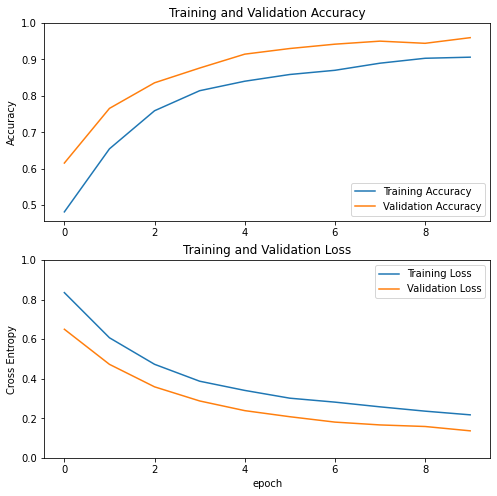

In [148]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
- In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

-  To increase performance even further we can fine-tune the weights of the top layers of the pre-trained model.

### Un-freeze the top layers of the model

In [149]:
base_model.trainable = True

In [150]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [151]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compile the model
As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [152]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [153]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

### Continue training the model

In [154]:
fine_tune_epochs = epochs + 10

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 20s 170ms/step - loss: 0.1572 - accuracy: 0.9350 - val_loss: 0.0624 - val_accuracy: 0.9726
Epoch 11/20
63/63 [==============================] - 10s 156ms/step - loss: 0.1195 - accuracy: 0.9525 - val_loss: 0.0532 - val_accuracy: 0.9774
Epoch 12/20
63/63 [==============================] - 10s 156ms/step - loss: 0.1102 - accuracy: 0.9500 - val_loss: 0.0552 - val_accuracy: 0.9810
Epoch 13/20
63/63 [==============================] - 10s 154ms/step - loss: 0.1045 - accuracy: 0.9545 - val_loss: 0.0490 - val_accuracy: 0.9810
Epoch 14/20
63/63 [==============================] - 9s 139ms/step - loss: 0.0945 - accuracy: 0.9620 - val_loss: 0.0497 - val_accuracy: 0.9774
Epoch 15/20
63/63 [==============================] - 9s 139ms/step - loss: 0.0781 - accuracy: 0.9690 - val_loss: 0.1043 - val_accuracy: 0.9583
Epoch 16/20
63/63 [==============================] - 10s 155ms/step - loss: 0.0815 - accuracy: 0.9670 - val_loss: 0.0417 - val_accuracy: 0.9810
Epoch 

In [155]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

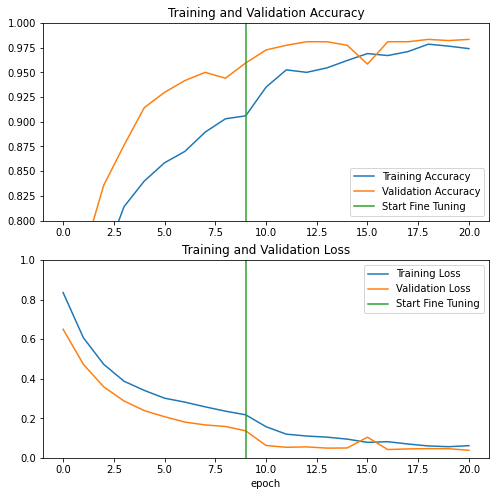

In [156]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

In [157]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 0s 40ms/step - loss: 0.0322 - accuracy: 0.9812
Test accuracy : 0.981249988079071


## Summary
- Using a pre-trained model for feature extraction: When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

- Fine-tuning a pre-trained model: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

## Lab Task:
- Increase and decrease the number of Un-freezed layers during fine-tuning and report how it will effect the performance.

### Effects of increasing the number of un-freezed layers

In [158]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/100), # Further decrease the learning rate to avoid overfitting
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [159]:
fine_tune_epochs = epochs + 10

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 27s 180ms/step - loss: 0.0500 - accuracy: 0.9810 - val_loss: 0.0394 - val_accuracy: 0.9833
Epoch 11/20
63/63 [==============================] - 9s 142ms/step - loss: 0.0497 - accuracy: 0.9795 - val_loss: 0.0396 - val_accuracy: 0.9833
Epoch 12/20
63/63 [==============================] - 10s 150ms/step - loss: 0.0464 - accuracy: 0.9805 - val_loss: 0.0402 - val_accuracy: 0.9821
Epoch 13/20
63/63 [==============================] - 10s 158ms/step - loss: 0.0441 - accuracy: 0.9825 - val_loss: 0.0304 - val_accuracy: 0.9881
Epoch 14/20
63/63 [==============================] - 11s 172ms/step - loss: 0.0331 - accuracy: 0.9890 - val_loss: 0.0318 - val_accuracy: 0.9869
Epoch 15/20
63/63 [==============================] - 10s 156ms/step - loss: 0.0496 - accuracy: 0.9815 - val_loss: 0.0378 - val_accuracy: 0.9821
Epoch 16/20
63/63 [==============================] - 10s 154ms/step - loss: 0.0392 - accuracy: 0.9835 - val_loss: 0.0344 - val_accuracy: 0.9857
Epoch

In [160]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 0s 43ms/step - loss: 0.0284 - accuracy: 0.9937
Test accuracy : 0.9937499761581421


### Decreasing number of un-freezed layers

In [161]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 140

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [162]:
fine_tune_epochs = epochs + 10

history_fine = model.fit(train_dataset,
                         epochs=fine_tune_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 16s 160ms/step - loss: 0.0390 - accuracy: 0.9855 - val_loss: 0.0391 - val_accuracy: 0.9845
Epoch 11/20
63/63 [==============================] - 10s 149ms/step - loss: 0.0432 - accuracy: 0.9860 - val_loss: 0.0348 - val_accuracy: 0.9833
Epoch 12/20
63/63 [==============================] - 10s 157ms/step - loss: 0.0386 - accuracy: 0.9845 - val_loss: 0.0382 - val_accuracy: 0.9845
Epoch 13/20
63/63 [==============================] - 9s 134ms/step - loss: 0.0328 - accuracy: 0.9860 - val_loss: 0.0279 - val_accuracy: 0.9881
Epoch 14/20
63/63 [==============================] - 10s 149ms/step - loss: 0.0383 - accuracy: 0.9825 - val_loss: 0.0386 - val_accuracy: 0.9845
Epoch 15/20
63/63 [==============================] - 9s 146ms/step - loss: 0.0399 - accuracy: 0.9845 - val_loss: 0.0320 - val_accuracy: 0.9869
Epoch 16/20
63/63 [==============================] - 9s 145ms/step - loss: 0.0278 - accuracy: 0.9895 - val_loss: 0.0334 - val_accuracy: 0.9857
Epoch 1

In [163]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 0s 37ms/step - loss: 0.0377 - accuracy: 0.9875
Test accuracy : 0.987500011920929


### Conclusion: Generalization accuracies (validation & testing) increase when increasing the number of un-freezed layers and vice versa. This is naturally what is expected due to allowing the adaptaion of the model more to this specific dataset when increasing the number of trainable parameters by un-freezing layers.